# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

import pandas as pd
import openpyxl
import sys
sys.path.insert(1, '../../../../mri_sim')
sys.path.insert(1, '../../..')

sys.path.insert(0, '../../../../mri_sim/SSFP')
from simulator import *

# Functions
### Quadratic Phase

In [2]:
#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    phi_quad = 360/N
    phase_shift = phi_quad*n*n/2
    phase_shift = phase_shift%360
 
    #in degree
    return phase_shift


<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>


### Quadratic RF spoiling bSSFP - data simulation function
### with Noise and Field inhomogeneous

In [3]:
#Add different field inhomogeneous effect (different T2*) and random noise to the Model 
#Both applied in F-state 
#Field inhomogeneous - use field inhomogeneous coefficient T2' (calculated for the target T2* range). Gaussian distribution convolution in image space --> exponential in Fouerier space 
#Noise - random noise on each F-state with std = F0/sqrt(N)* 5%

def quadratic_RFspoiling_bSSFP (T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, TRnum, M_transverse, off_resonance_f, T2p, testnum, AddNoise, Noise):
    
    SimulatedData = np.asarray(np.zeros((1,testnum,off_resonance_f.shape[0])), dtype = float) #Array with (T2*num, noise num, off-res f num)
    T2Star_GT = np.asarray([], dtype = float) #Store the Ground Truth T2*
     
    #For different T2*
    for T2_inhom in T2p:
        SimulatedData_slice = np.asarray(np.zeros((1,off_resonance_f.shape[0])), dtype = float)
        #Store Ground truth T2*------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))
        
        #Add inhomogeneous, get the off-resonance profile with inhomogeneous effect added
        F_magnitude_inhomo, F_state = AddfieldInhomogeneous(M_transverse, TR, TE, T2_inhom, off_resonance_f)
        
        #Add Noise
        for test in range (0, testnum ):
            if (AddNoise == True):
                F_magnitude_inhomo_noise = F_magnitude_inhomo + Noise[test,:]
            else:
                F_magnitude_inhomo_noise = F_magnitude_inhomo
            SimulatedData_slice = np.append(SimulatedData_slice, F_magnitude_inhomo_noise.reshape(1,off_resonance_f.shape[0]), axis = 0)
        SimulatedData_slice = np.delete(SimulatedData_slice,0,0)
        SimulatedData = np.append(SimulatedData, SimulatedData_slice.reshape(1,testnum,off_resonance_f.shape[0]), axis = 0)
    SimulatedData = np.delete(SimulatedData,0,0)
        
#         #______________________T2* Fit________TESTING______________________________
#         F_state_magnitude, F_state = Fstate (M_transverse_noise)
        
#         F_state = np.round(F_state).astype(int) #round F-state all to integer 
#         F = np.asarray([], dtype = float)
#         F_Magnitude = np.asarray([], dtype = float)
#         for i in range (0,6):
#             F_index = np.where(F_state == float(-1-2*i))

#             F = np.append(F, i)
#             F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
            
#         #End

#         ## time = TE+F*TR
#         time = TE*np.ones(np.shape(F))+ F *TR
        
#         def func(t, A, R2Star):
#             return A * np.exp(-R2Star * t)
#         #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
#         popt, pcov = curve_fit(func, time, F_Magnitude)
        
#         plt.figure(1)
#         plt.plot(time, F_Magnitude)
#         T2Star_measured = 1/popt[1]
#         print(T2Star_GT)
#         print(T2Star_measured)
#         #______________________________TESTING______________________________
        
    #Reshape into 3D Array(T2*num, noise num, off-res f num)    
    #SimulatedData = SimulatedData.reshape(np.shape(T2p)[0], testnum, np.shape(M_transverse_inhomo_noise)[-1])   
        
    return SimulatedData, T2Star_GT

In [4]:
#Off-resonance profile magnitude --> F-state magnitude 
def Fstate(M_transverse):
    F_Magnitude = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(M_transverse), axis = 0))/M_transverse.shape[0]
    # F_Magnitude = np.fft.fftshift(M_transverse)
    # F_Magnitude = np.fft.fft(F_Magnitude, axis = 0)/M_transverse.shape[-1]
    # F_Magnitude = np.fft.ifftshift(F_Magnitude)
    

    F_state = np.fft.fftfreq(M_transverse.shape[0], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[0]
    
    return np.transpose(F_Magnitude), np.transpose(F_state)


<p>Add field inhomogeneous <p\>

In [5]:
#Add field inhomogeneous to model T2* effect (for F_number F-states, F_number = 6 --> 0,1,2...5 F-states
def AddfieldInhomogeneous(M_transverse, TR, TE, T2prime, off_resonance_f):
   
    #F-state
    F_state_magnitude, F_state = Fstate(M_transverse)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 
    F_state_magnitude_inhomo = F_state_magnitude
    
    index = 0
    for i in F_state:
        #remove the empty state caused by taking 2 period off-res profile 
        if ((i%2) == 0):
            F = np.abs(-i//2) #the right F-state (all cast to positive)
            time = TE+ F *TR
            if (T2prime == 0):
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index]
            else:
                F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index] *np.exp(-time/T2prime)
        index = index + 1 
    #End
    
    return F_state_magnitude_inhomo, F_state


### T2* value fit using simulated data

In [6]:
#Performing T2* Fit using the previous simulated data (F-state)
def T2StarFit(Data, T2Star_GT, Period, TR, sampleT2s):
    #testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
    #each row store measured T2* value for a ground truth T2*
    TE = TR/2
    
    testnumber = np.shape(Data)[1]
    T2s_m_all = np.asarray([], dtype = float)
    #testnumber*2 matrix storing mean error and sd
    Mean = np.asarray([], dtype = float)
    Errorstd = np.asarray([], dtype = float)
    Bias = np.asarray([], dtype = float)

    slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*
    
    # plt.figure()
    # plt.xlabel("T2* Ground Truth (s)")
    # plt.ylabel("T2* Measured (s)")
    # x1 = np.array([-2,5])
    # y1 = np.array([-2,5])
    # plt.plot(x1,y1,c = '#4CAF50')
    # plt.xlim(10e-3, 60e-3)
    # plt.ylim(10e-3, 60e-3)
    # plt.grid()
    
    for GroundTruth in T2Star_GT:
        T2s_m = np.asarray([], dtype = float)
        for test in range (0,testnumber):
            #select each line from dataset 
            F_state_magnitude = Data[slicenum, test, :]
            F_state = np.fft.fftshift(np.fft.fftfreq(F_state_magnitude.shape[-1], d = 1.0))*F_state_magnitude.shape[-1]

            #______________________T2* Fit______________________________________
            

            #fit using 6 or less F-states
            F_state = np.round(F_state).astype(int) #round F-state all to integer 
            F = np.asarray([], dtype = float)
            F_Magnitude = np.asarray([], dtype = float)
            for i in range (0,Period):
                F_index = np.where(F_state == float(2+2*i))

                F = np.append(F, i)
                F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
            #End

            ## time = TE+F*TR
            time = TE*np.ones(np.shape(F))+ F *TR

            def func(t, A, R2Star):
                return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
            popt, pcov = curve_fit(func, time, F_Magnitude)

            T2Star_measured = 1/popt[1]
            T2s_m = np.append(T2s_m, T2Star_measured)
            
            if (GroundTruth == sampleT2s*1e-3):
                plt.figure(2)
                plt.plot(time, F_Magnitude, marker = 'o')
                plt.xlabel("Time (s)")
                plt.ylabel("F state magnitude")
                plt.title("F-states T2* fitting(Monte Carlo Simulation) for T2* = "+str(GroundTruth)+" s")
            
        
            #____________________________________________________________
        #For End
        #plt.scatter([GroundTruth]*testnumber, T2s_m)
       
        
        #calculate error
        #T2s_m_all = np.append(T2s_m_all, T2s_m)
        #Error_test = np.square(T2s_m - GroundTruth)
        #Error_test = T2s_m - GroundTruth
        T2s_m_mean = np.mean(T2s_m)
        Mean = np.append(Mean, T2s_m_mean)
        Errorstd = np.append(Errorstd, np.std(T2s_m))
        Bias = np.append(Bias, (T2s_m_mean-GroundTruth)/GroundTruth)
        slicenum = slicenum + 1
        
    #For End

    return Mean, Errorstd, Bias
    #T2s_m_all = T2s_m_all.reshape(T2Star_GT.shape[-1], testnumber)

#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")

In [7]:
#Performing T2* Fit using the previous simulated data (F-state)
def FStateExpFit(Data, T2Star_GT, Period, TR, FA):
    #testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
    #each row store measured T2* value for a ground truth T2*
    TE = TR/2
    
    testnumber = np.shape(Data)[1]
    T2s_m_all = np.asarray([], dtype = float)
    T1_m_all = np.asarray([], dtype = float)
    #testnumber*2 matrix storing mean error and sd
    Mean = np.asarray([], dtype = float)
    Errorstd = np.asarray([], dtype = float)
    Bias = np.asarray([], dtype = float)

    slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*
    
    # plt.figure()
    # plt.xlabel("T2* Ground Truth (s)")
    # plt.ylabel("T2* Measured (s)")
    # x1 = np.array([-2,5])
    # y1 = np.array([-2,5])
    # plt.plot(x1,y1,c = '#4CAF50')
    # plt.xlim(10e-3, 60e-3)
    # plt.ylim(10e-3, 60e-3)
    # plt.grid()
    
    for GroundTruth in T2Star_GT:
        T2s_m = np.asarray([], dtype = float)
        T1_m = np.asarray([], dtype = float)
        for test in range (0,testnumber):
            #select each line from dataset 
            F_state_magnitude = Data[slicenum, test, :]
            F_state = np.fft.fftshift(np.fft.fftfreq(F_state_magnitude.shape[-1], d = 1.0))*F_state_magnitude.shape[-1]

            #______________________T2* Fit______________________________________
            

            #fit using 6 or less F-states
            F_state = np.round(F_state).astype(int) #round F-state all to integer 
            F = np.asarray([], dtype = float)
            F_Magnitude = np.asarray([], dtype = float)
            for i in range (0,Period):
                F_index = np.where(F_state == float(2+2*i))

                F = np.append(F, i)
                F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
            #End

            ## time = TE+F*TR
            time = TE*np.ones(np.shape(F))+ F *TR

            def func(t, A, R2Star):
                return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
            popt, pcov = curve_fit(func, time, F_Magnitude)

            plt.figure(2)
            plt.plot(time, F_Magnitude, marker = 'o')
            T2Star_measured = 1/popt[1]
            T1_measured = -TR/(np.log((popt[0]-math.sin(FA))/(popt[0]*math.cos(FA)-math.sin(FA))))
            T2s_m = np.append(T2s_m, T2Star_measured)
            T1_m = np.append(T1_m, T1_measured)
        T2s_m_all = np.append(T2s_m_all, np.mean(T2s_m))
        T1_m_all = np.append(T1_m_all, np.mean(T1_m))
            #____________________________________________________________
        #For End
        #plt.scatter([GroundTruth]*testnumber, T2s_m)
       
        
        #calculate error
        
        # T2s_m_mean = np.mean(T2s_m)
        # Mean = np.append(Mean, T2s_m_mean)
        # Errorstd = np.append(Errorstd, np.std(T2s_m))
        # Bias = np.append(Bias, (T2s_m_mean-GroundTruth)/GroundTruth)
        slicenum = slicenum + 1
        
    #For End

    return T2s_m_all, T1_m_all
    #T2s_m_all = T2s_m_all.reshape(T2Star_GT.shape[-1], testnumber)

#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")

# Simulation Parameters

In [8]:
#Map resoluation
TR_n = 1

#number of simulation run
testnumber = 100
AddNoise = True


#------------------------------------------------------------------------
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 800e-3
T2 = 44e-3
off_res_samplesize = 1000

TR = 6e-3
TE = TR/2
#number of TR
Nr = 500
# tip angle alpha 10
tip_angle = 10
alpha = [np.deg2rad(tip_angle)] * Nr

#initial magnetisation 
M0 = 1
#off resonance profile range
f = 4
off_res = np.linspace(-np.pi*f, np.pi*f, off_res_samplesize+1)
off_res = off_res[0:-1]
dphi = [0]* Nr

#T2* range 13 ms to 53 ms
T2s_min = 13
T2s_max = 53
T2p = np.asarray([], dtype = float)

for i in range (T2s_min, T2s_max):
    T2p = np.append(T2p, 1/((1000/i)-1/T2))
        


In [9]:
#phase cycling
Period = 5
phi = []
for i in range (0,Nr):
    p = np.deg2rad(QuadraticPhase(Period,i))
    phi.append(p)
    

# Simulate Data
<p>Bloch simulation<p/>

Text(0.5, 1.0, 'F State Profile with field inhomogenous added')

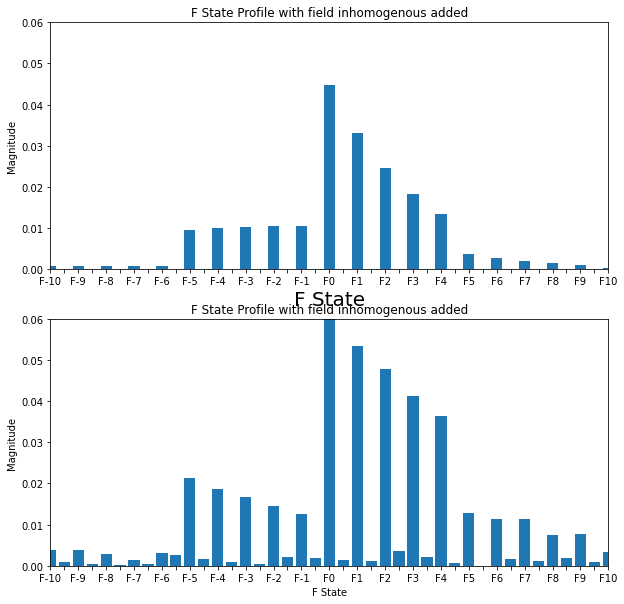

In [15]:
Figre, a = plt.subplots(2, figsize = (10,10))

F_m = F_inhomo_Plot
a[0].set_xticks(F_state_ax, labels = ["F"+str(round(i/2)) if i%2==0 else "" for i in np.round(F_state_ax)])
a[0].bar(F_state_ax, np.absolute(F_m[0,:]))
a[0].set_xlim(-20, 20)
a[0].set_ylim(0,0.06)
a[0].set_xlabel("F State")
a[0].set_ylabel("Magnitude")
a[0].set_title("F State Profile with field inhomogenous added")

#Add Noise base on the f-state plot after inhomogenous field is added
F0_ref = np.abs(F_inhomo_Plot[0,np.where(F_state == int(2))])
Noise_sd = 1/np.sqrt(Period)*F0_ref*0.05
Noise = np.random.normal(0,Noise_sd,(1,off_res_samplesize)) + 1j*np.random.normal(0,Noise_sd,(1,off_res_samplesize))

F_magnitude_inhomo_noise = F_magnitude_inhomo + Noise[0,:]

F_m = F_magnitude_inhomo_noise
a[1].set_xticks(F_state_ax, labels = ["F"+str(round(i/2)) if i%2==0 else "" for i in np.round(F_state_ax)])
a[1].bar(F_state_ax, np.absolute(F_m[0,:]))
a[1].set_xlim(-20, 20)
a[1].set_ylim(0,0.06)
a[1].set_xlabel("F State")
a[1].set_ylabel("Magnitude")
a[1].set_title("F State Profile with field inhomogenous added")

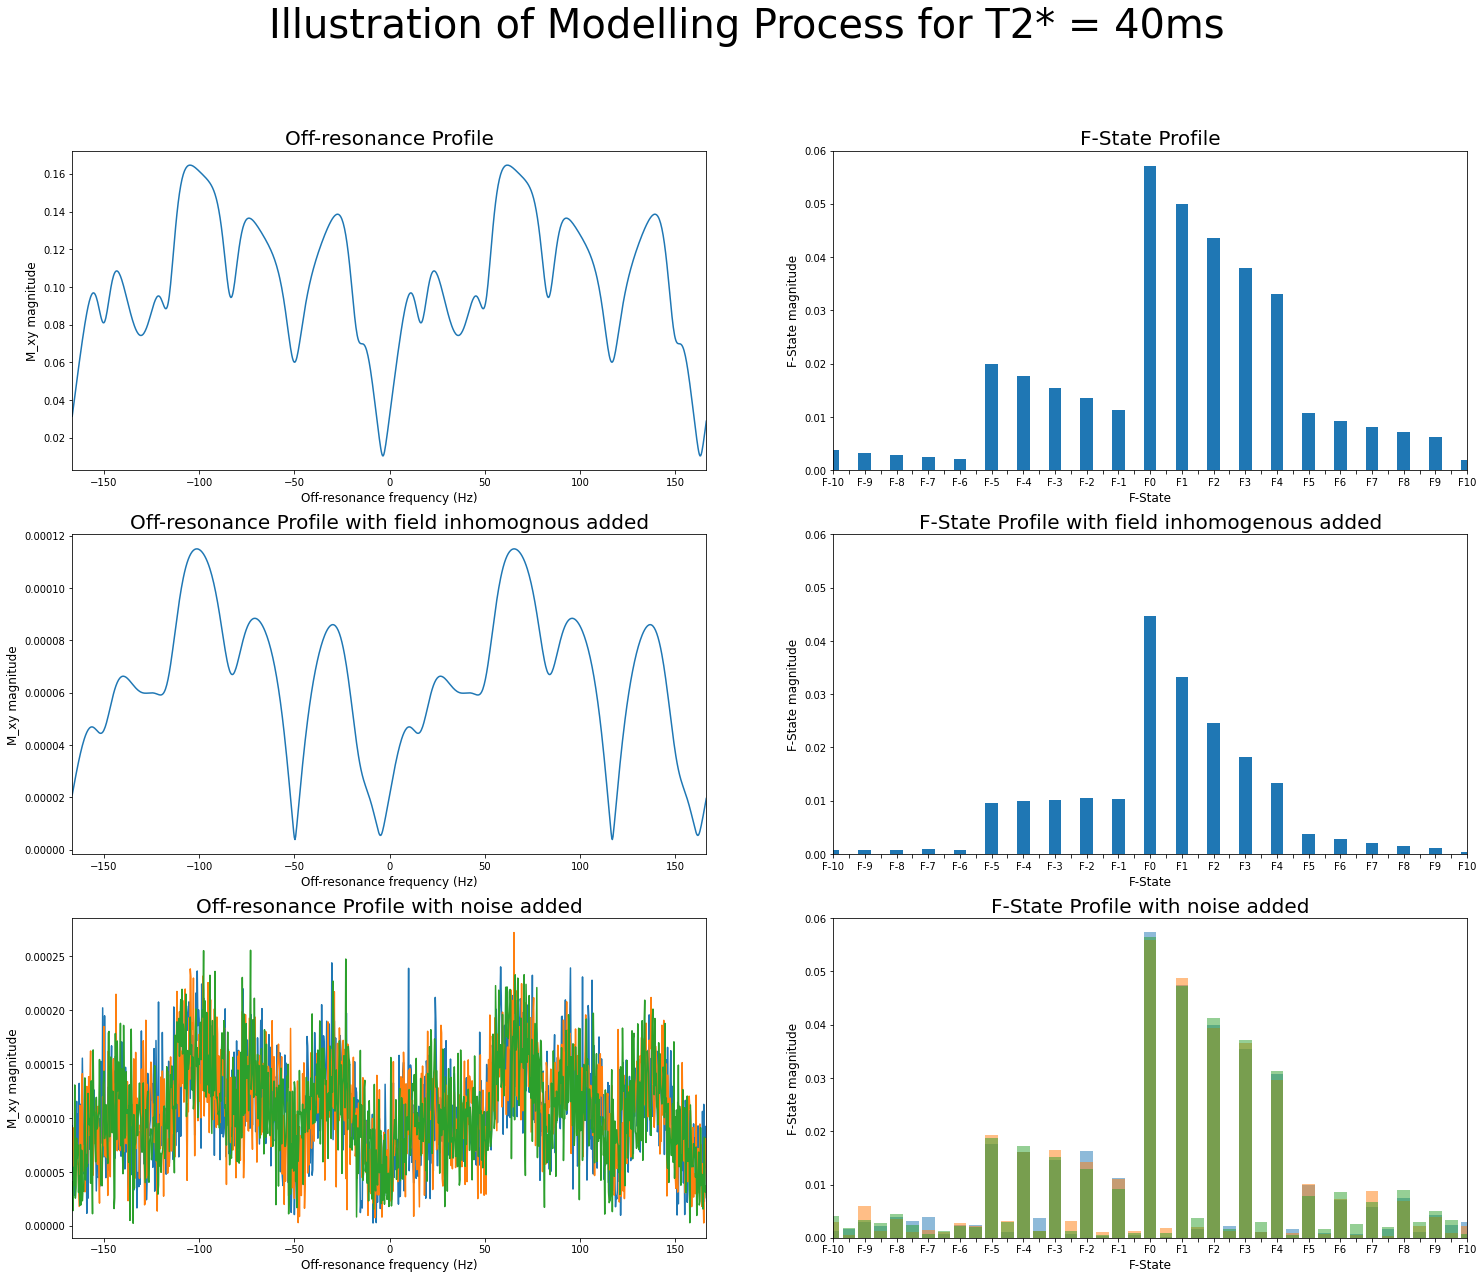

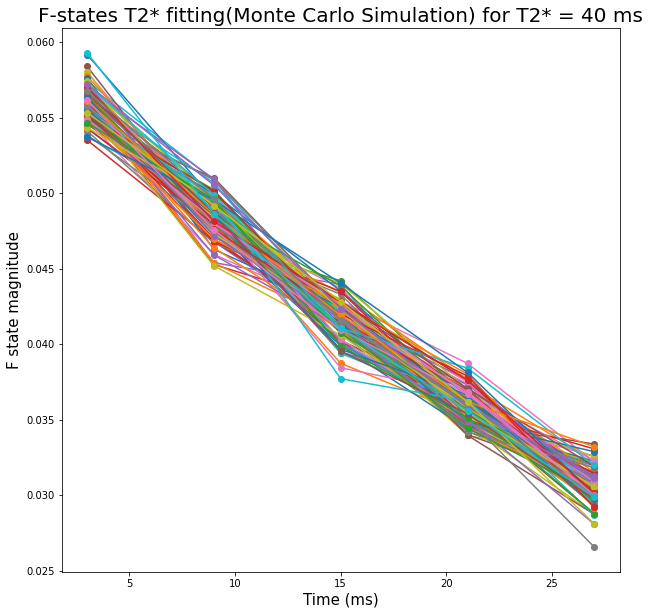

In [28]:
SampleT2s_p = [40, 1/((1000/20)-1/T2)]
ErrorMeanfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
Errorstdfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
Biasfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)
Meanfigdata = np.asarray(np.zeros((1,np.shape(T2p)[0])), dtype = float)

fig, ax = plt.subplots(3,2, figsize = (25,20))
fig.suptitle("Illustration of Modelling Process for T2* = 40ms", fontsize = 40)

fig_fit, ax2 = plt.subplots(figsize = (10,10))
ax2.set_title("F-states T2* fitting(Monte Carlo Simulation) for T2* = 40 ms", fontsize = 20)
ax2.set_xlabel("Time (ms)", fontsize = 15)
ax2.set_ylabel("F state magnitude", fontsize = 15)

####---------------------------------DATA SIMULATION START---------------------------------###

##STEP 1---Generate bSSFP off-resonance profile using Bloch simulation----------------------## 

TR_list = [TR *1e3] * Nr 
TE = TR/2
#Bloch simulation, only T1 and T2 effect considered, no field inhomogenous take into account
off_resonance_f, M_transverse =  blochc(off_res, off_res_samplesize, M0 = M0 , alpha = alpha, phi = phi, dphi = dphi, TR= TR_list, TE= TE*1e3, T1 = T1*1e3, T2 = T2*1e3)
off_resonance_f = off_resonance_f/2 #One period should be 1/TR, make the axis looks right

#-----------PLOT F STATE--------------
ax[0,0].plot(off_resonance_f, np.abs(M_transverse))
ax[0,0].set_xlim(off_resonance_f[0],off_resonance_f[-1])
ax[0,0].set_xlabel("Off-resonance frequency (Hz)", fontsize = 12)
ax[0,0].set_ylabel("M_xy magnitude", fontsize = 12)
ax[0,0].set_title("Off-resonance Profile", fontsize = 20)

F_m, F_ax = Fstate(M_transverse)
F_state_ax = F_ax-2
ax[0,1].set_xticks(F_state_ax, labels = ["F"+str(round(i/2)) if i%2==0 else "" for i in np.round(F_state_ax)])
ax[0,1].bar(F_state_ax, np.absolute(F_m[0,:]))
ax[0,1].set_xlim(-20, 20)
ax[0,1].set_ylim(0,0.06)
ax[0,1].set_xlabel("F-State", fontsize = 12)
ax[0,1].set_ylabel("F-State magnitude", fontsize = 12)
ax[0,1].set_title("F-State Profile", fontsize = 20)
#---------------------------------------


##STEP 2---Add different field inhomogeneous effect (different T2*) and random noise to the Model---## 

#Both applied in F-state 
#Field inhomogeneous - use field inhomogeneous coefficient T2' (calculated for the target T2* range). Gaussian distribution convolution in image space --> exponential in Fouerier space 
#Noise - random noise on each F-state with std = F0/sqrt(N)* 5%

SimulatedData = np.asarray(np.zeros((1,testnumber,off_resonance_f.shape[0])), dtype = float) #Array with (T2*num, noise num, off-res f num)
T2Star_GT = np.asarray([], dtype = float) #Store the Ground Truth T2*

#For different T2*
for T2_inhom in T2p:
    SimulatedData_slice = np.asarray(np.zeros((1,off_resonance_f.shape[0])), dtype = float)
    #Store Ground truth T2*------------------------------------
    T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))

    #Add inhomogeneous, get the off-resonance profile with inhomogeneous effect added
    F_magnitude_inhomo, F_state = AddfieldInhomogeneous(M_transverse, TR, TE, T2_inhom, off_resonance_f)
    
    #------Only for Plot generation-----------
    if(T2_inhom == SampleT2s_p[1]):
        F_inhomo_Plot = F_magnitude_inhomo
    #-----------------------------------------
    
    #Add Noise base on the f-state plot after inhomogenous field is added
    F0_ref = np.abs(F_magnitude_inhomo[0,np.where(F_state == int(2))])
    Noise_sd = 1/np.sqrt(Period)*F0_ref*0.05
    Noise = np.random.normal(0,Noise_sd,(testnumber,off_res_samplesize)) + 1j*np.random.normal(0,Noise_sd,(testnumber,off_res_samplesize))

    for test in range (0, testnumber):
        if (AddNoise == True):
            F_magnitude_inhomo_noise = F_magnitude_inhomo + Noise[test,:]
        else:
            F_magnitude_inhomo_noise = F_magnitude_inhomo
        SimulatedData_slice = np.append(SimulatedData_slice, F_magnitude_inhomo_noise.reshape(1,F_magnitude_inhomo_noise.shape[1]), axis = 0)
    SimulatedData_slice = np.delete(SimulatedData_slice,0,0)
    SimulatedData = np.append(SimulatedData, SimulatedData_slice.reshape(1,testnumber,F_magnitude_inhomo_noise.shape[1]), axis = 0)
SimulatedData = np.delete(SimulatedData,0,0)

#-----------PLOT Inhomo F STATE--------------
M_transverse_inhomo = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(F_inhomo_Plot)))*F_inhomo_Plot.shape[0]
ax[1,0].plot(off_resonance_f, np.abs(M_transverse_inhomo[0,:]))
ax[1,0].set_xlim(off_resonance_f[0],off_resonance_f[-1])
ax[1,0].set_xlabel("Off-resonance frequency (Hz)", fontsize = 12)
ax[1,0].set_ylabel("M_xy magnitude", fontsize = 12)
ax[1,0].set_title("Off-resonance Profile with field inhomognous added", fontsize = 20)

F_m = F_inhomo_Plot
ax[1,1].set_xticks(F_state_ax, labels = ["F"+str(round(i/2)) if i%2==0 else "" for i in np.round(F_state_ax)])
ax[1,1].bar(F_state_ax, np.absolute(F_m[0,:]))
ax[1,1].set_xlim(-20, 20)
ax[1,1].set_ylim(0,0.06)
ax[1,1].set_xlabel("F-State", fontsize = 12)
ax[1,1].set_ylabel("F-State magnitude", fontsize = 12)
ax[1,1].set_title("F-State Profile with field inhomogenous added", fontsize = 20)
#---------------------------------------

#-----------PLOT Noise F STATE--------------
index = np.where(T2Star_GT == SampleT2s_p[0]*1e-3)[0]
M_transverse_noise = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(SimulatedData[index,0,:])))*SimulatedData[index,0,:].shape[0]
ax[2,0].plot(off_resonance_f, np.abs(M_transverse_noise[0,:]))
ax[2,0].set_xlim(off_resonance_f[0],off_resonance_f[-1])
ax[2,0].set_xlabel("Off-resonance frequency (Hz)", fontsize = 12)
ax[2,0].set_ylabel("M_xy magnitude", fontsize = 12)
ax[2,0].set_title("Off-resonance Profile with noise added", fontsize = 20)

F_m = SimulatedData[index,0,:]
ax[2,1].set_xticks(F_state_ax, labels = ["F"+str(round(i/2)) if i%2==0 else "" for i in np.round(F_state_ax)])
ax[2,1].bar(F_state_ax, np.absolute(F_m[0,:]),alpha = 0.5)
ax[2,1].set_xlim(-20, 20)
ax[2,1].set_ylim(0,0.06)
ax[2,1].set_xlabel("F-State", fontsize = 12)
ax[2,1].set_ylabel("F-State magnitude", fontsize = 12)
ax[2,1].set_title("F-State Profile with noise added", fontsize = 20)

M_transverse_noise = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(SimulatedData[index,2,:])))*SimulatedData[index,0,:].shape[0]
ax[2,0].plot(off_resonance_f, np.abs(M_transverse_noise[0,:]))

F_m = SimulatedData[index,2,:]
ax[2,1].bar(F_state_ax, np.absolute(F_m[0,:]),alpha = 0.5)

M_transverse_noise = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(SimulatedData[index,3,:])))*SimulatedData[index,0,:].shape[0]
ax[2,0].plot(off_resonance_f, np.abs(M_transverse_noise[0,:]))

F_m = SimulatedData[index,3,:]
ax[2,1].bar(F_state_ax, np.absolute(F_m[0,:]),alpha = 0.5)

#---------------------------------------    
####---------------------------------DATA SIMULATION END--------------------------------------###


####---------------------------------T2* FITTING START----------------------------------------###
#Performing T2* Fit using the previous simulated data (F-state)

#testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
#each row store measured T2* value for a ground truth T2*
testnumber = np.shape(SimulatedData)[1]
T2s_m_all = np.asarray([], dtype = float)
#testnumber*2 matrix storing mean error and sd
Mean = np.asarray([], dtype = float)
Errorstd = np.asarray([], dtype = float)
Bias = np.asarray([], dtype = float)

slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*

for GroundTruth in T2Star_GT:
    T2s_m = np.asarray([], dtype = float)
    for test in range (0,testnumber):
        #select each line from dataset 
        F_state_magnitude = SimulatedData[slicenum, test, :]
        F_state = np.fft.fftshift(np.fft.fftfreq(F_state_magnitude.shape[-1], d = 1.0))*F_state_magnitude.shape[-1]

        #______________________T2* Fit______________________________________


        #fit using 6 or less F-states
        F_state = np.round(F_state).astype(int) #round F-state all to integer 
        F = np.asarray([], dtype = float)
        F_Magnitude = np.asarray([], dtype = float)
        for i in range (0,Period):
            F_index = np.where(F_state == float(2+2*i))

            F = np.append(F, i)
            F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
        #End

        ## time = TE+F*TR
        time = TE*np.ones(np.shape(F))+ F *TR

        def func(t, A, R2Star):
            return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
        popt, pcov = curve_fit(func, time, F_Magnitude)

        T2Star_measured = 1/popt[1]
        T2s_m = np.append(T2s_m, T2Star_measured)

        if (GroundTruth == SampleT2s_p[0]*1e-3):
            #-----------PLOT T2* fittings --------------
            ax2.plot(time*1e3, F_Magnitude, marker = 'o')
            #-------------------------------------------
        #____________________________________________________________
    #For End

    T2s_m_mean = np.mean(T2s_m)
    Mean = np.append(Mean, T2s_m_mean)
    Errorstd = np.append(Errorstd, np.std(T2s_m))
    Bias = np.append(Bias, (T2s_m_mean-GroundTruth)/GroundTruth)
    slicenum = slicenum + 1

    #For End



In [30]:
# fig.savefig("Illustration_of_ModellingT2Star_40ms.jpg")
# #fig_fit.savefig("Illustration_T2StarFitting_40ms.jpg")

<Figure size 432x288 with 0 Axes>

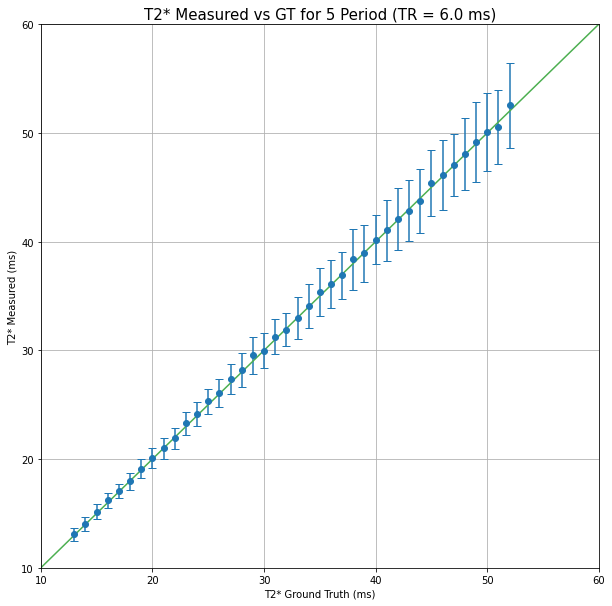

In [32]:
from math import log10, floor
plt.figure(1)
fig, ax = plt.subplots(figsize = (10,10))

ax.errorbar(T2Star_GT*1e3,Mean*1e3,fmt='o', yerr=Errorstd*1e3,capsize=4)
ax.set_xlabel("T2* Ground Truth (ms)")
ax.set_ylabel("T2* Measured (ms)")
ax.set_title("T2* Measured vs GT for "+str(Period)+" Period (TR = "+str(round(TR*1e3, 3-int(floor(log10(abs(TR*1e3))))-1))+" ms)", fontsize = 15)
x1 = np.array([-20,60])
y1 = np.array([-20,60])
ax.plot(x1,y1,c = '#4CAF50')
ax.set_xlim(10, 60)
ax.set_ylim(10, 60)
ax.grid()
plt.savefig("Illustration_ModelVariation_T2StarMeasuredvsGT_5Period_6TR_40ms.jpg")

In [71]:
# np.save("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_ErrorMean.npy", ErrorMeanfigdata)
# np.save("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Errorstd.npy", Errorstdfigdata)
# np.save("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Bias.npy", Biasfigdata)
# np.save("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Mean.npy", Meanfigdata)

In [13]:
# #Load Data
# Period = 11
# T2Star_GT = np.asarray([], dtype = float)
# for T2_inhom in T2p:
#         #Store Ground truth T2*------------------------------------
#         T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))
        
# ErrorMeanfigdata = np.load("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_ErrorMean.npy")
# Errorstdfigdata = np.load("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Errorstd.npy")
# Biasfigdata = np.load("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Bias.npy")
# Meanfigdata = np.load("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"PeriodData_0.05Noise_Mean.npy")

In [80]:
errormeancb = np.asarray([],dtype = float)
for i in range(-10,125):
    errormeancb = np.append(errormeancb, 0.04*i)

Text(0.5, 1.0, '12 Period error mean map')

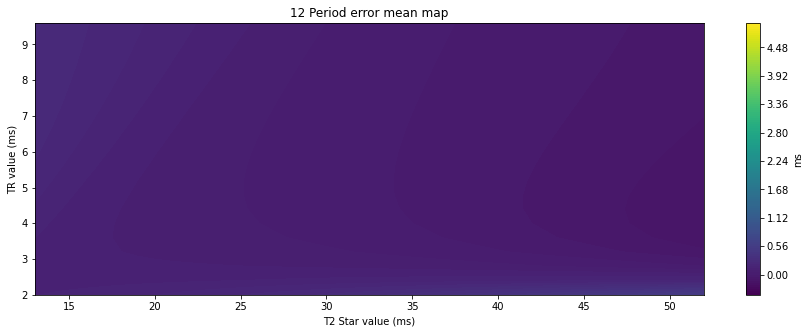

In [81]:
errormap, mapax = plt.subplots(figsize = (15,5))

contourImage = mapax.contourf(T2Star_GT*1e3,TR*1e3,ErrorMeanfigdata*1e3,errormeancb)
c_map_m = errormap.colorbar(contourImage, ax=mapax)
c_map_m.set_label("ms")

mapax.set_xlabel("T2 Star value (ms)")
mapax.set_ylabel("TR value (ms)")
mapax.set_title(str(Period)+" Period error mean map")
#plt.savefig("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"Period_TR_T2StarMeanErrorMap.jpg")

In [94]:
errorstdcb = np.asarray([],dtype = float)
for i in range(0,150):
    errorstdcb = np.append(errorstdcb, 0.1*i)

Text(0.5, 1.0, '12 Period error standard deviation map')

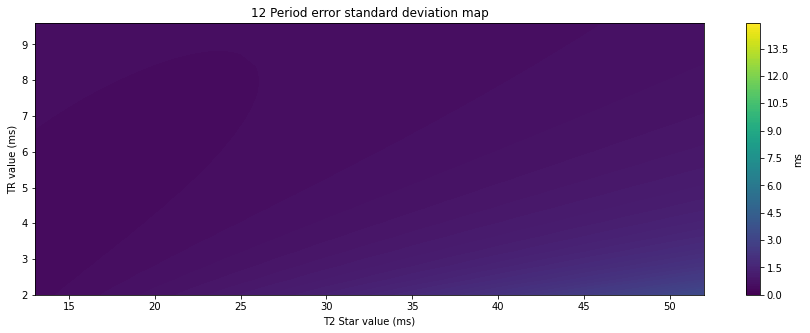

In [95]:
errorstdmap, std_mapax = plt.subplots(figsize = (15,5))

contourImage = std_mapax.contourf(T2Star_GT*1e3,TR*1e3,Errorstdfigdata*1e3,errorstdcb)
c_bar_sd = errorstdmap.colorbar(contourImage, ax=std_mapax)
c_bar_sd.set_label("ms")

std_mapax.set_xlabel("T2 Star value (ms)")
std_mapax.set_ylabel("TR value (ms)")
std_mapax.set_title(str(Period)+" Period error standard deviation map")
#plt.savefig("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"Period_TR_T2StarErrorSDMap.jpg")

In [90]:
biascb = np.asarray([],dtype = float)
for i in range(0,100):
    biascb = np.append(biascb, 0.05*i)

Text(0.5, 1.0, '12 Period bias map')

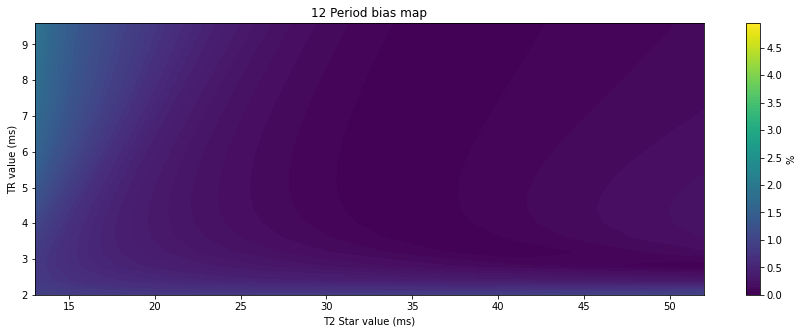

In [91]:
biasmap, bias_mapax = plt.subplots(figsize = (15,5))

contourImage = bias_mapax.contourf(T2Star_GT*1e3,TR*1e3,np.abs(Biasfigdata)*100,biascb)
c_bar_b = biasmap.colorbar(contourImage, ax=bias_mapax)
c_bar_b.set_label("%")
bias_mapax.set_xlabel("T2 Star value (ms)")
bias_mapax.set_ylabel("TR value (ms)")
bias_mapax.set_title(str(Period)+" Period bias map")
#plt.savefig("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/"+str(Period)+"Period_TR_T2StarBiasMap.jpg")

C:\Users\jinje\AppData\Local\Temp\ipykernel_10232\4196819941.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize = (10,10))


<Figure size 432x288 with 0 Axes>

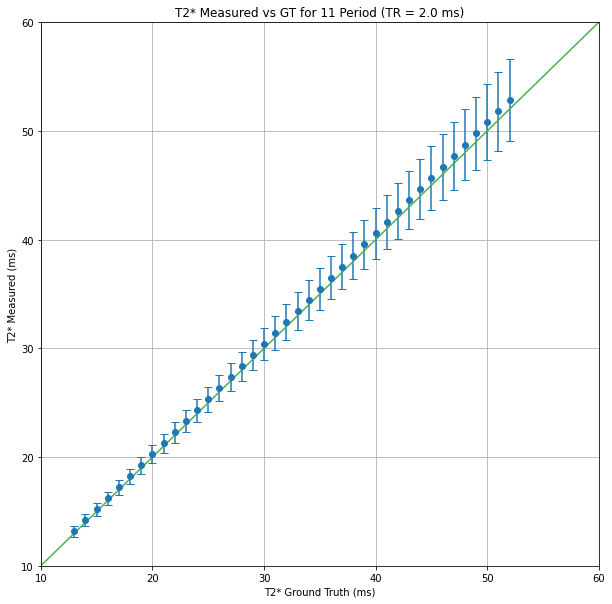

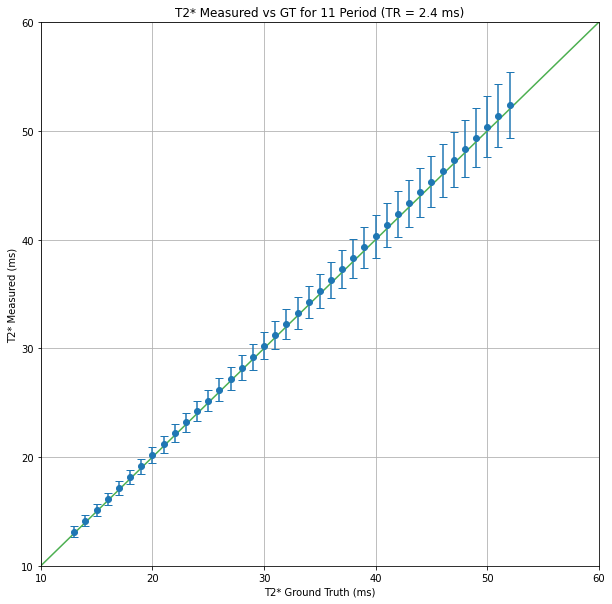

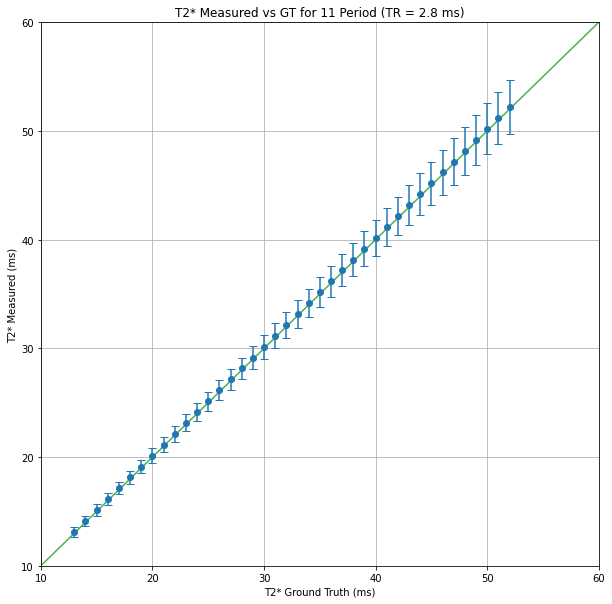

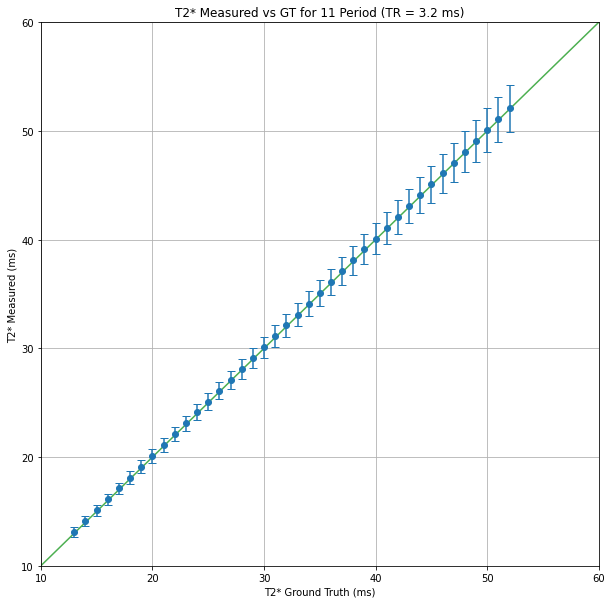

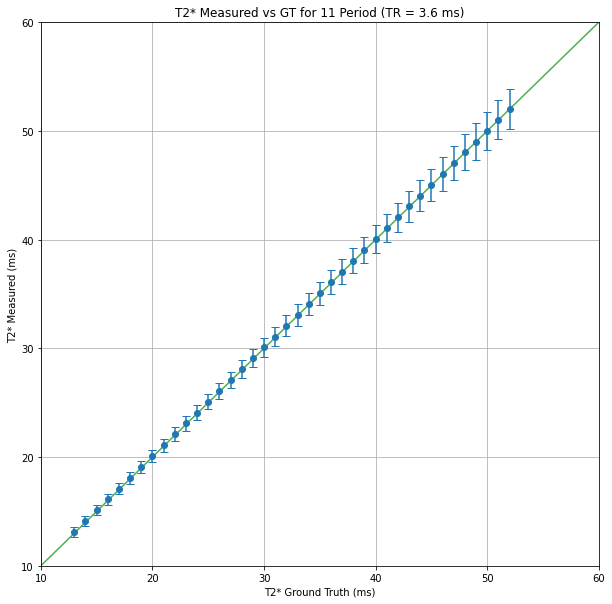

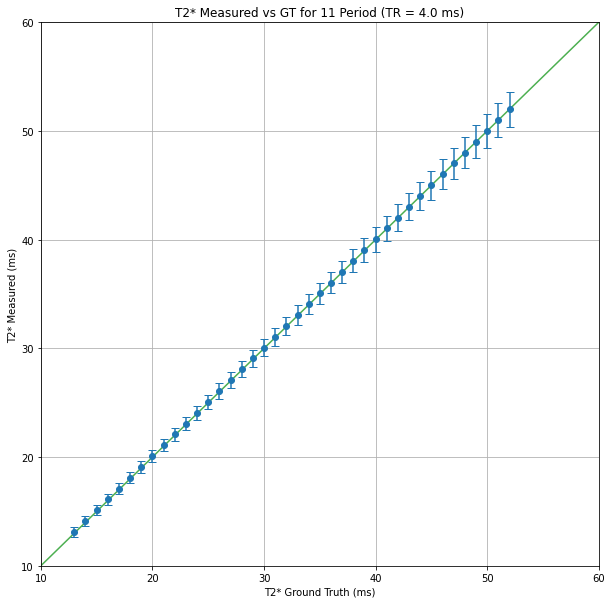

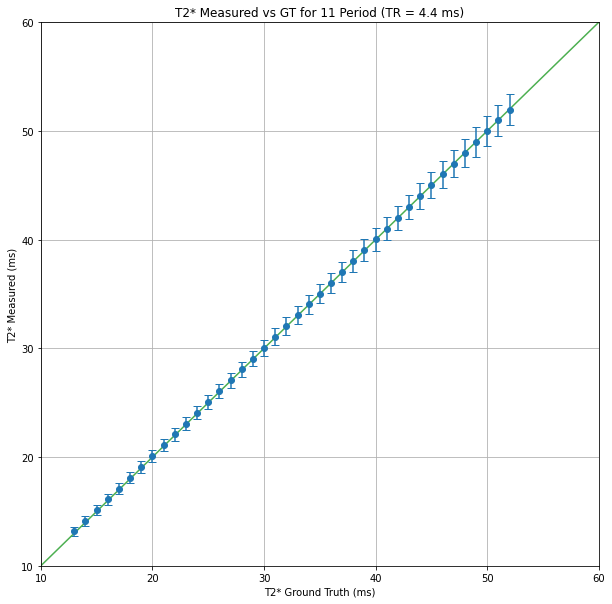

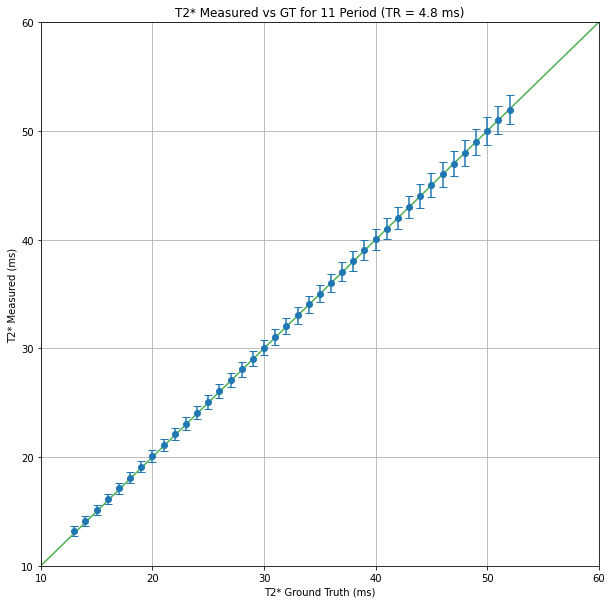

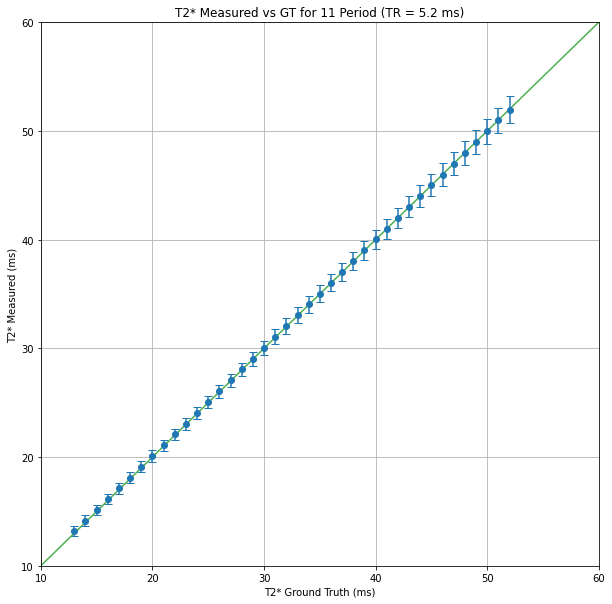

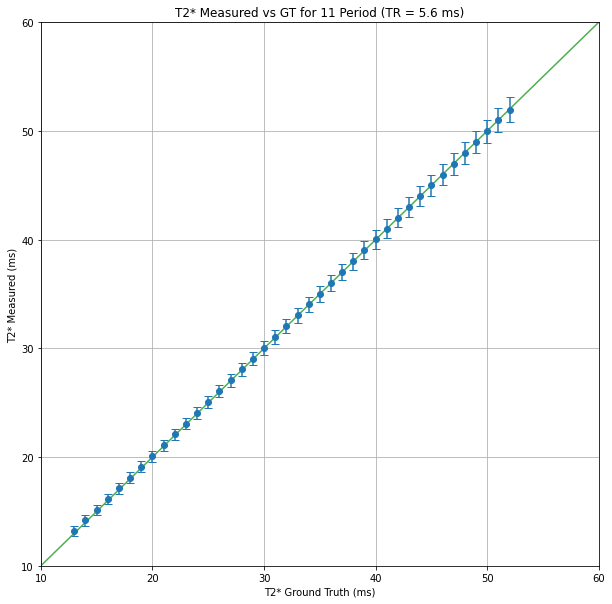

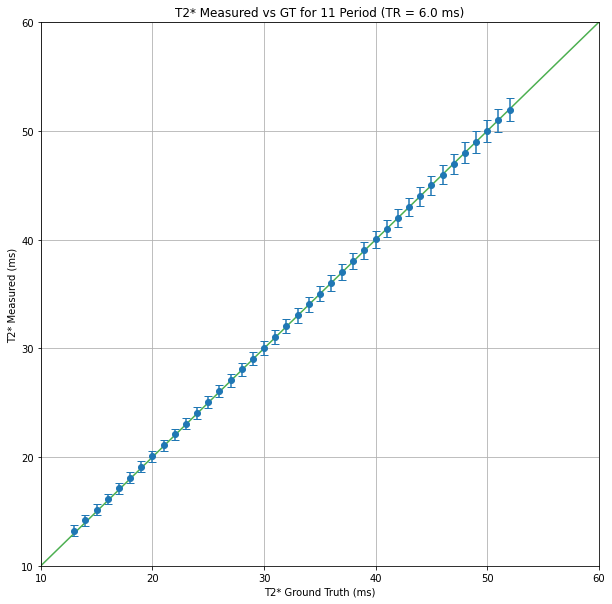

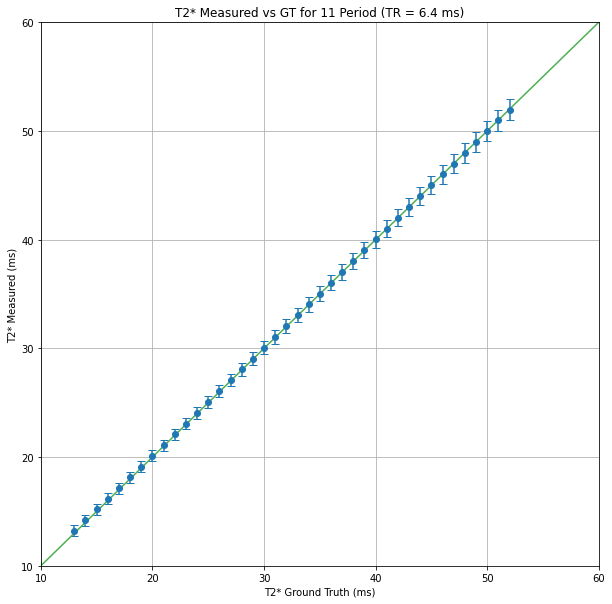

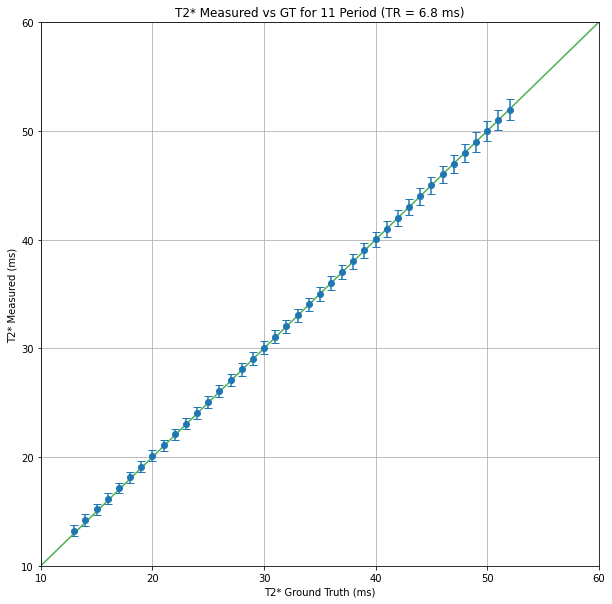

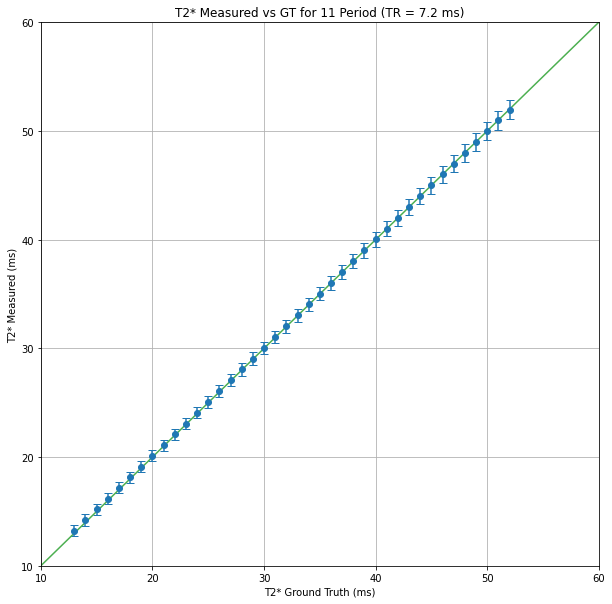

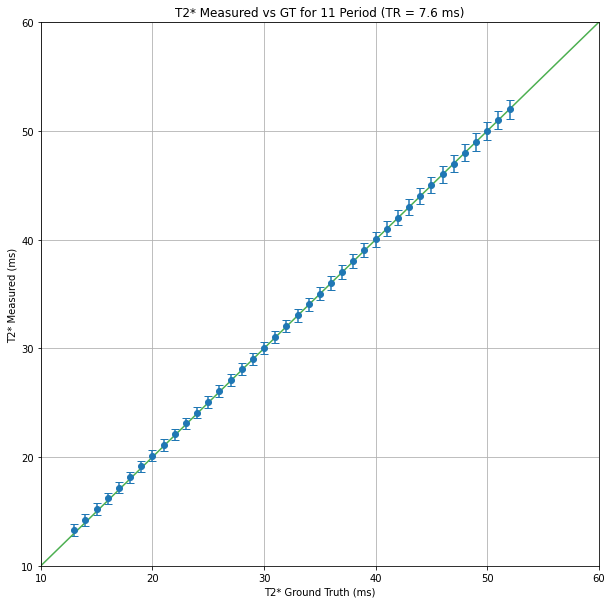

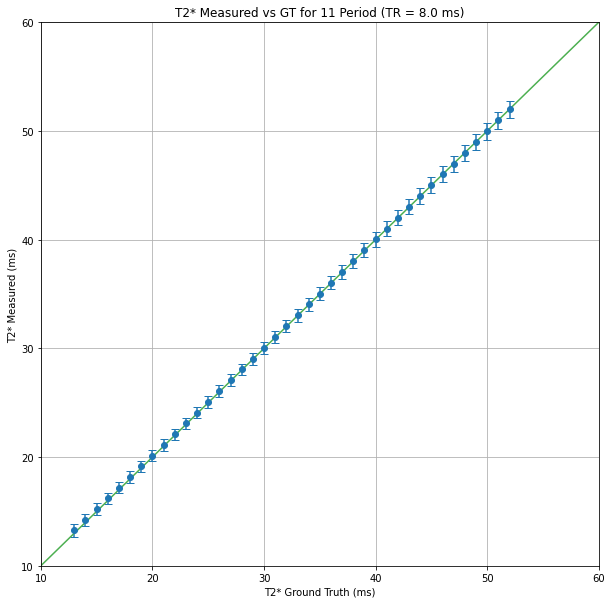

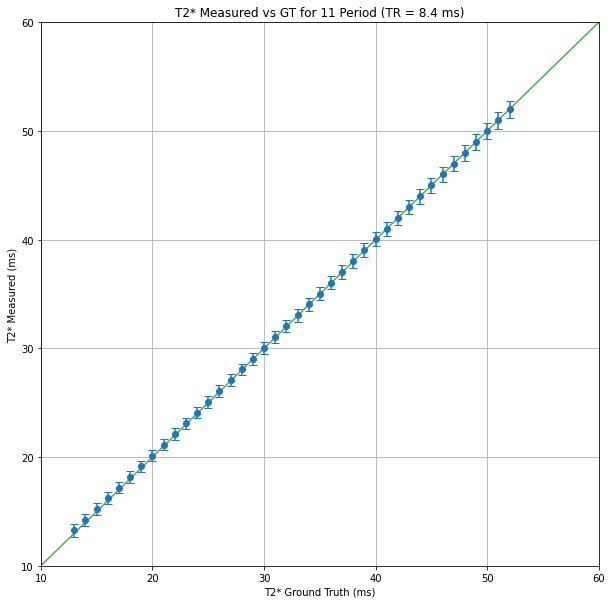

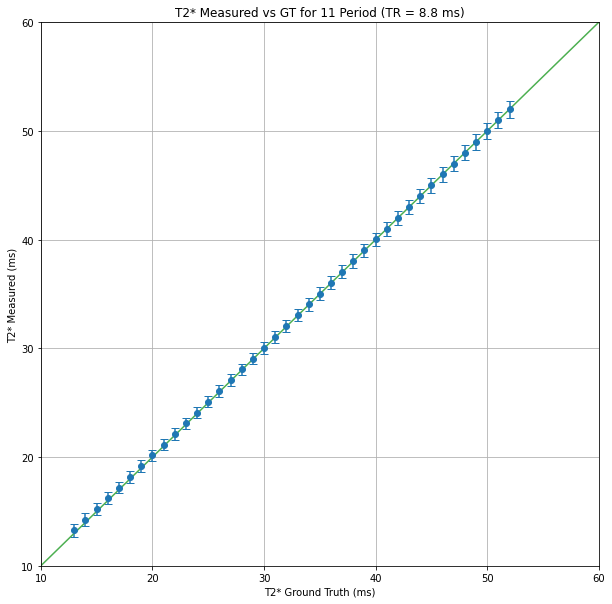

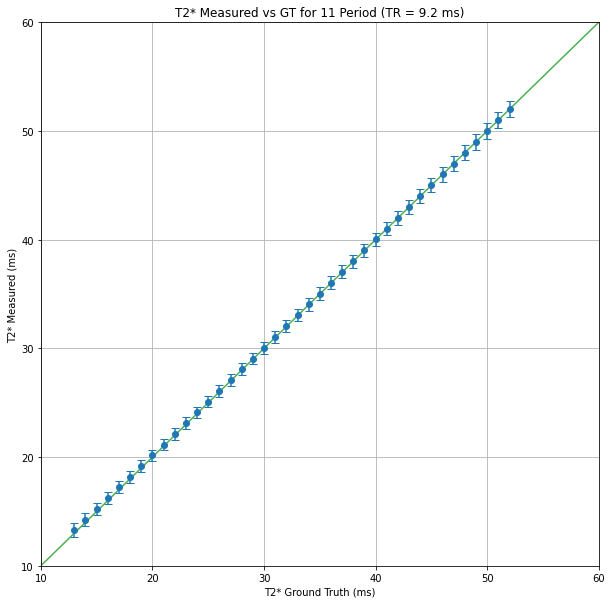

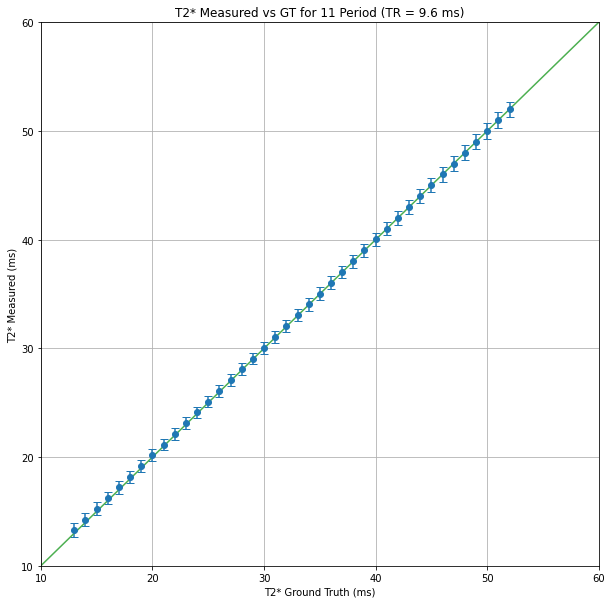

In [14]:
from math import log10, floor
#Plot to see T2* accuracy at different TRs
for i in range(0,20):
    plt.figure(i+1)
    fig, ax = plt.subplots(figsize = (10,10))

    ax.errorbar(T2Star_GT*1e3,Meanfigdata[i,:]*1e3,fmt='o', yerr=Errorstdfigdata[i,:]*1e3,capsize=4)
    ax.set_xlabel("T2* Ground Truth (ms)")
    ax.set_ylabel("T2* Measured (ms)")
    ax.set_title("T2* Measured vs GT for "+str(Period)+" Period (TR = "+str(round(TR[i]*1e3, 3-int(floor(log10(abs(TR[i]*1e3))))-1))+" ms)")
    x1 = np.array([-20,60])
    y1 = np.array([-20,60])
    ax.plot(x1,y1,c = '#4CAF50')
    ax.set_xlim(10, 60)
    ax.set_ylim(10, 60)
    ax.grid()
    fig.savefig("./Figure/"+str(Period)+"Period_0.05Noise_"+str(TR_n)+"TRs/T2StarAccuracy_"+str(Period)+"_Period_TR_"+str(round(TR[i]*1e3, 3-int(floor(log10(abs(TR[i]*1e3))))-1))+"_ms.jpg")

# Visualise the RF spoiling phase angle

0.0
25.714285714285715
102.85714285714286
231.42857142857142
51.428571428571445
282.8571428571429
205.71428571428567


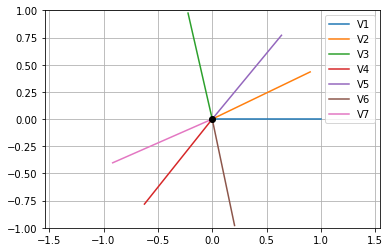

In [57]:
#Visualise the RF quadratic spoiling angle
Period = 7

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
V = np.asarray([[0,0]], dtype = float)
for i in range (0,Period):
    p = QuadraticPhase(Period,i)
    phaseshift_rad = np.radians(p-(p//360))
    tmp = p 
    tmp = tmp % 360
    print(tmp)
    #line_1 = plt.Line2D([0,math.cos(phaseshift_rad)], [0,math.sin(phaseshift_rad)], linewidth=1, linestyle = "-", label = i)
    #ax.add_line(line_1)

    V = np.append(V,[[math.cos(phaseshift_rad),math.sin(phaseshift_rad)]], axis =0)
    

V = np.delete(V, 0,0)
# origin = np.array(np.zeros((2,Period))) # origin point
# plt.quiver(*origin, V[:,0], V[:,1], scale=5)
# plt.show()

# ax.set(xlim=[-1,1])
# ax.set(ylim=[-1,1])
#print(V)

rows,cols =V.T.shape

#Get absolute maxes for axis ranges to center origin
#This is optional
maxes = 1.1*np.amax(abs(V), axis = 0)

for i,l in enumerate(range(0,cols)):
    xs = [0,V[i,0]]
    ys = [0,V[i,1]]
    plt.plot(xs,ys)

plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-1,1]) #<-- set the x axis limits
plt.ylim([-1,1]) #<-- set the y axis limits
plt.legend(['V'+str(i+1) for i in range(cols)]) #<-- give a legend
plt.grid(True) #<-- plot grid lines
plt.show()

## 